# Customer Segmentation using Clustering
This notebook performs customer segmentation using unsupervised learning techniques. The goal is to identify distinct customer groups based on their purchasing behavior.

####-- Import dependencies --

In [467]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime as dt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

####-- Load Dataset --

In [468]:
data = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

####-- Initial Data Exploration --

In [ ]:
df = data.copy()

In [469]:
df.shape

(541909, 8)

In [470]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


####-- Data Preprocessing --

In [471]:
# -- Removing CustomerID column --
df.drop(['StockCode','Description','Country'], axis=1, inplace=True)

In [472]:
# -- Removing NaN values --
df.dropna(inplace=True)

In [473]:
# -- Checking duplicates --
df.duplicated().value_counts()

,count
False,255400
True,151429


In [474]:
# -- Dropping duplicates --
df.drop_duplicates(inplace=True)

####-- Column-wise Preprocessing --

In [475]:
# -- Converting alpha-numeric 'InvoiceNo' column to numeric --
df['InvoiceNo'].replace(r'[A-Za-z]', '', regex=True, inplace=True)
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'])

In [476]:
# -- Checking values in 'Quantity' column --
df['Quantity'].apply(lambda x: f"{x:.0f}").sort_values(ascending=True).unique()

array(['-1', '-10', '-100', '-102', '-108', '-11', '-110', '-112', '-113',
       '-12', '-120', '-1200', '-121', '-126', '-1296', '-13', '-130',
       '-1300', '-132', '-1350', '-14', '-140', '-144', '-15', '-150',
       '-1515', '-152', '-16', '-160', '-162', '-164', '-168', '-17',
       '-18', '-180', '-184', '-186', '-19', '-192', '-1930', '-2', '-20',
       '-200', '-2000', '-21', '-22', '-220', '-23', '-234', '-24',
       '-240', '-244', '-25', '-250', '-252', '-26', '-27', '-276', '-28',
       '-288', '-29', '-3', '-30', '-300', '-31', '-3114', '-312', '-318',
       '-32', '-324', '-33', '-334', '-34', '-35', '-36', '-360', '-37',
       '-38', '-39', '-4', '-40', '-400', '-408', '-42', '-420', '-43',
       '-432', '-45', '-46', '-468', '-47', '-48', '-480', '-49', '-5',
       '-50', '-500', '-51', '-52', '-53', '-576', '-58', '-6', '-60',
       '-600', '-624', '-64', '-66', '-67', '-670', '-68', '-7', '-70',
       '-701', '-72', '-720', '-74215', '-75', '-756', '-76'

In [477]:
# -- Treating negative values in Quantity column --
df['Quantity'] = df['Quantity'].abs()

In [478]:
# -- Checking values in 'UnitPrice' column --
df['UnitPrice'].apply(lambda x: f"{x:.2f}").sort_values(ascending=True).unique()

array(['0.00', '0.01', '0.03', '0.04', '0.06', '0.07', '0.08', '0.09',
       '0.10', '0.11', '0.12', '0.14', '0.16', '0.17', '0.18', '0.19',
       '0.20', '0.21', '0.22', '0.24', '0.25', '0.27', '0.28', '0.29',
       '0.30', '0.32', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39',
       '0.40', '0.41', '0.42', '0.45', '0.48', '0.50', '0.52', '0.53',
       '0.55', '0.56', '0.58', '0.59', '0.62', '0.63', '0.64', '0.65',
       '0.66', '0.67', '0.68', '0.69', '0.70', '0.72', '0.73', '0.74',
       '0.75', '0.76', '0.77', '0.78', '0.79', '0.80', '0.82', '0.83',
       '0.85', '0.86', '0.87', '0.90', '0.91', '0.92', '0.94', '0.95',
       '0.98', '1.00', '1.01', '1.02', '1.04', '1.05', '1.06', '1.08',
       '1.10', '1.11', '1.12', '1.18', '1.19', '1.23', '1.24', '1.25',
       '1.27', '1.31', '1.32', '1.38', '1.40', '1.43', '1.45', '1.46',
       '1.48', '1.49', '1.50', '1.53', '1.55', '1.60', '1.63', '1.64',
       '1.65', '1.66', '1.67', '1.68', '1.69', '1.70', '1.71', '1.72',
      

In [479]:
# -- Treating rows with UnitPrice = 0 --
df = df[df['UnitPrice'] > 0]

In [480]:
# -- Adding column 'TotalPrice' --
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

-- Using RFM Analysis --

In [481]:
# -- Entracting features from 'datetime' --
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate':lambda x : (reference_date-x.max()).days,
    'InvoiceNo':'nunique',
    'TotalPrice':'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [482]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,154367.20
1,12347.0,2,7,3125.98
2,12348.0,75,4,1399.80
3,12349.0,19,1,1209.49
4,12350.0,310,1,174.20


-- Scaling data --

In [483]:
# -- Feature Scaling --
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

####-- Multi-Model Training --

-- K-Means Clustering --

In [484]:
# -- Elbow method --
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

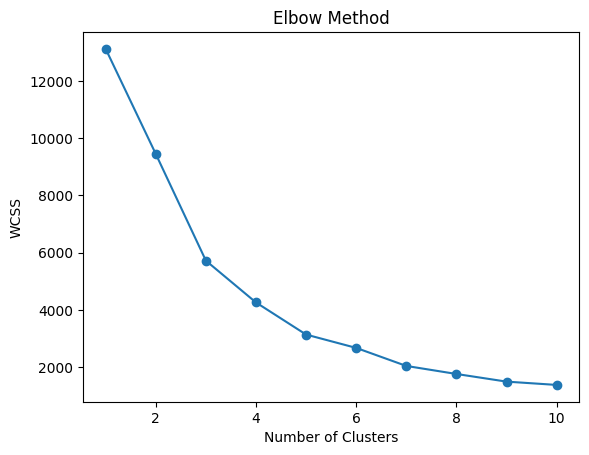

In [485]:
# -- Plotting elbow curve --
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

Selecting k = 5 for K-means clustering

In [486]:
# -- Training Model --
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)
score_kmeans = silhouette_score(rfm_scaled, kmeans_labels)

-- Agglomerative Clustering --

In [487]:
# -- Training Model --
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(rfm_scaled)
score_agg = silhouette_score(rfm_scaled, agg_labels)

-- DBSCAN Clustering --

In [488]:
# -- Training Model --
dbscan = DBSCAN(eps=0.3,min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm_scaled)
score_dbscan = silhouette_score(rfm_scaled, dbscan_labels)
print(f'{score_dbscan:.3f}')

0.756


In [489]:
# -- Comparing Evaluation Scores --
print(f"KMeans Silhouette Score      : {score_kmeans:.3f}")
print(f"Agglomerative Silhouette Score: {score_agg:.3f}")
print(f"DBSCAN Silhouette Score      : {score_dbscan:.3f}")

KMeans Silhouette Score      : 0.602
Agglomerative Silhouette Score: 0.563
DBSCAN Silhouette Score      : 0.756


DBSCAN has the best score, but it forms very few number of clusters (one or two)

-- Visualizing Clusters --

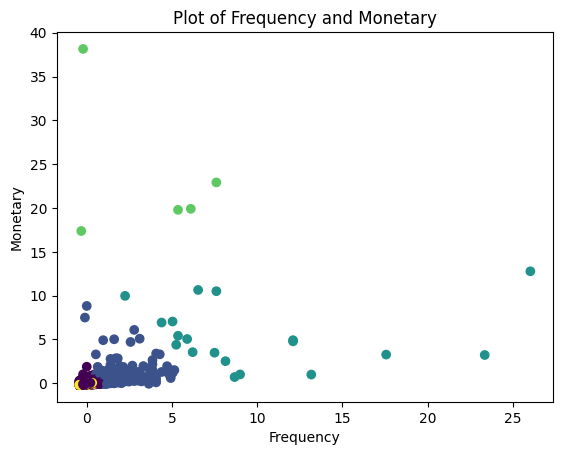

In [491]:
rfm_scaled = pd.DataFrame(data=rfm_scaled,columns=['Recency', 'Frequency', 'Monetary'])

plt.scatter(rfm_scaled['Frequency'], rfm_scaled['Monetary'], c=kmeans_labels, marker='o')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Plot of Frequency and Monetary')
plt.show()